### Duel output UNet on pennate diatoms - first attempt
### Rayna Hamilton
### March 21, 2025

We will train a UNet neural network to detect the locations of pennate diatom cells in strained microscopy images.  This cell segmentation approach was first introduced by [Ronnenberger et al., 2015](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28).  My initial testing with this code suggested that nearby cells are often merged together by this segmentation approach, so I am taking from inspiration from the [Duel-Output Unet approach](https://github.com/ToyahJade/DO-U-Net), which addressed the issue of close-together objects by training a network to detect both objects and outlines, then subtracting the outline prediction from the object body prediction.  For this application, I am just going to train two networks, one on cell body annotations, and one on cell outlines.  The ultimate goal of this project is to predict the parasite infection status of each individual cell, but to do this we first need to determine the locations of boundaries of individual cells in the images.

In [ ]:
# U-NET CNN Approach to Automated Image Analysis
    # base code from: https://www.kaggle.com/code/vbookshelf/simple-cell-segmentation-with-keras-and-u-net
#-------------------------------------------------------------------------------------------------------------

# Read in libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
# %matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
# warnings.filterwarnings('ignore')

IMG_TILE_SIZE=400
IMG_CHANNELS = 3 # RGB


In [2]:
# Read in data
mother_directory = "../../data/test_images/" 
    # home of analyzed output images & csvs
child_directory_image = "ML_output/images/"
child_directory_csv = "ML_output/csvs/"


if not os.path.isdir(child_directory_csv):
    os.mkdir(child_directory_csv)
if not os.path.isdir(child_directory_image):
    os.mkdir(child_directory_image)

#-------------------------------------------------------------------------------------------------------------

# get a list of files in each folder
mask_dir = "../../data/binary_masks/"
outline_mask_dir = "../../data/outlines/"

img_list = os.listdir(mother_directory)
img_list=[val for val in img_list if val.endswith(".jpg")]
mask_list = os.listdir(mask_dir)
mask_list=[val for val in mask_list if val.endswith(".jpg")]
outline_mask_list = os.listdir(outline_mask_dir)
outline_mask_list=[val for val in outline_mask_list if val.endswith(".jpg")]

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

df_images

image_id
0     AS_A_I_15_4-20240720.jpg
1     AS_A_I_22_4-20240718.jpg
2     AS_A_I_22_5-20240718.jpg
3     AS_B_I_15_4-20240724.jpg
4     AS_B_I_22_5-20240720.jpg
5     AS_B_I_22_6-20240717.jpg
6     AS_B_U_15_1-20240726.jpg
7     AS_C_I_15_2-20240726.jpg
8     AS_C_I_15_3-20240724.jpg
9     AS_C_U_15_3-20240717.jpg
10   AS_Starter_1-20240711.jpg
11   AS_STARTER_2-20240716.jpg
12   AS_Starter_3-20240711.jpg
13   AS_STARTER_5-20240716.jpg
14   THN_A_I_15_1-20240717.jpg
15   THN_A_I_15_1-20240724.jpg
16   THN_A_I_22_1-20240717.jpg
17   THN_A_I_22_3-20240724.jpg
18   THN_B_I_15_5-20240726.jpg
19   THN_C_I_15_3-20240724.jpg
20   THN_C_I_15_4-20240720.jpg
21   THN_C_I_22_2-20240720.jpg
22  THN_STARTER_1-20240716.jpg
23  THN_Starter_2-20240711.jpg
24  THN_STARTER_4-20240716.jpg
25  THN_Starter_5-20240711.jpg

The training data labels are termed binary masks, meaning that all pixels in the image are either 1 (cell) or 0 (non-cell).  Currently, I have more cell body annotations than cell outline annotations, but hopefully we will have more annotations of both for subsequent runs.

In [3]:
# ================================================
# Add a column indicating if an image has a mask for outline and cell contents
# ================================================

def check_for_mask(x):
    x=x.replace(".jpg",".jpg")
    if x in [val.replace("_masks","") for val in somelist]:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
somelist=mask_list
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)
somelist=outline_mask_list
df_images['has_outline_mask'] = df_images['image_id'].apply(check_for_mask)
df_images

image_id has_mask has_outline_mask
0     AS_A_I_15_4-20240720.jpg      yes               no
1     AS_A_I_22_4-20240718.jpg      yes               no
2     AS_A_I_22_5-20240718.jpg      yes               no
3     AS_B_I_15_4-20240724.jpg      yes               no
4     AS_B_I_22_5-20240720.jpg      yes               no
5     AS_B_I_22_6-20240717.jpg      yes               no
6     AS_B_U_15_1-20240726.jpg      yes               no
7     AS_C_I_15_2-20240726.jpg      yes               no
8     AS_C_I_15_3-20240724.jpg      yes               no
9     AS_C_U_15_3-20240717.jpg      yes               no
10   AS_Starter_1-20240711.jpg      yes               no
11   AS_STARTER_2-20240716.jpg      yes               no
12   AS_Starter_3-20240711.jpg      yes               no
13   AS_STARTER_5-20240716.jpg      yes               no
14   THN_A_I_15_1-20240717.jpg      yes              yes
15   THN_A_I_15_1-20240724.jpg      yes              yes
16   THN_A_I_22_1-20240717.jpg      yes              yes
17   THN_A_I_22_3-20240724.jpg      yes              yes
18   THN_B_I_15_5-20240726.jpg      yes              yes
19   THN_C_I_15_3-20240724.jpg      yes              yes
20   THN_C_I_15_4-20240720.jpg      yes              yes
21   THN_C_I_22_2-20240720.jpg      yes              yes
22  THN_STARTER_1-20240716.jpg      yes              yes
23  THN_Starter_2-20240711.jpg      yes              yes
24  THN_STARTER_4-20240716.jpg      yes              yes
25  THN_Starter_5-20240711.jpg      yes              yes

In [4]:

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = [val for val in df_masks['image_id']]

df_masks.shape

(26, 4)

In [5]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
# Create empty arrays

X = np.zeros((len(image_id_list), 1040,1388,3), dtype=np.uint8)
y = np.zeros((len(image_id_list), 1040,1388), dtype=bool)
# X_train


for i, image_id in enumerate(image_id_list):
    path_image = mother_directory + image_id
    # read the image using skimage
    image = imread(path_image)
    X[i] = image
    
X.shape

(26, 1040, 1388, 3)

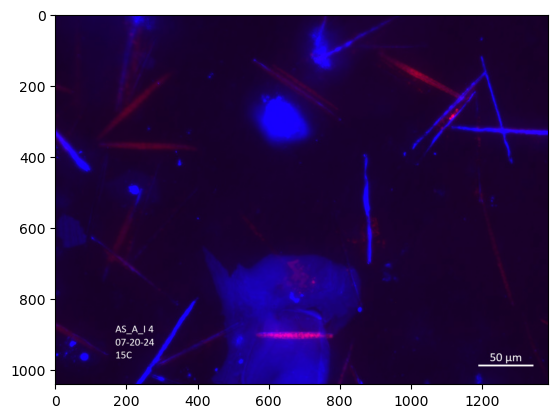

In [6]:
plt.imshow(X[0])

In the above sample image, blue lines are late-stage infected cells, and red lines are healthy cells.

In [7]:
y_cell,y_outline=[],[]
for i, mask_id in enumerate(mask_id_list):
    
    path_mask =mask_dir + mask_id
    # read the image using skimage
    mask = imread(path_mask.replace(".jpg","_masks.jpg"))[:,:,0]
    y_cell.append(mask)
    if mask_id.replace(".jpg","_masks.jpg") in outline_mask_list:
        path_mask =outline_mask_dir + mask_id
        mask = imread(path_mask.replace(".jpg","_masks.jpg"))
        y_outline.append(mask)
y_cell,y_outline=np.array(y_cell),np.array(y_outline)
y_cell.shape

(26, 1040, 1388)

In [8]:
y_outline.shape

(12, 1040, 1388)

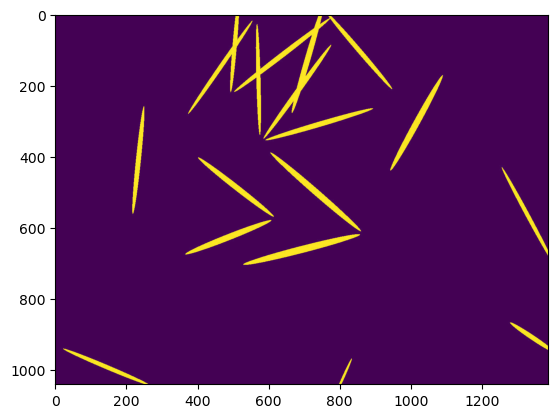

In [9]:
plt.imshow(y_cell[14])

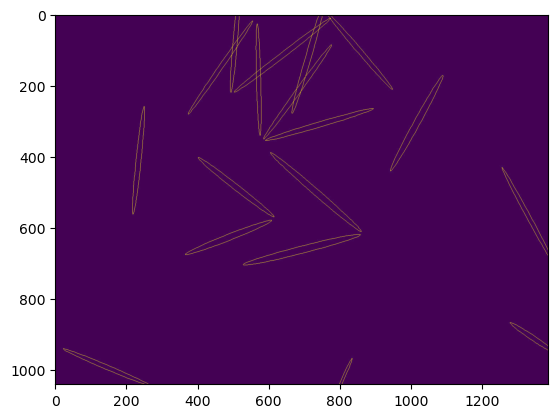

In [10]:
plt.imshow(y_outline[0])

In [11]:
X.shape

(26, 1040, 1388, 3)

Above are examples of the cell binary mask and outline annotation that will be used for training the networks.  Below I am splitting up the images into 400-by-400 pixel chunks, with some overlap between windows to augment our training data.  This is necessary as the network architecture requires square images and is quite picky about dimensions, but I have found that resizing the images results in an undesirable amount of distortion, particularly for the outlines.

In [12]:
tiled_x_cell,tiled_x_outline,tiled_y_cell,tiled_y_outline=[],[],[],[]

'''for X,y in zip(X_train,Y_train):
    for y_pos in range(0,700,100):
        for x_pos in range(0,400,100):
            tiled_x_train.append(X[x_pos:x_pos+600,y_pos:y_pos+600])
            tiled_y_train.append(y[x_pos:x_pos+600,y_pos:y_pos+600])'''

for i in range(len(X)):
    for y_pos in range(0,900,100):
        for x_pos in range(0,600,100):
            tiled_x_cell.append(X[i,x_pos:x_pos+400,y_pos:y_pos+400])
            tiled_y_cell.append(y_cell[i,x_pos:x_pos+400,y_pos:y_pos+400])
            if i>=14:
                tiled_x_outline.append(X[i,x_pos:x_pos+400,y_pos:y_pos+400])
                tiled_y_outline.append(y_outline[i-14,x_pos:x_pos+400,y_pos:y_pos+400])

tiled_x_cell,tiled_x_outline,tiled_y_cell,tiled_y_outline=np.array(tiled_x_cell),np.array(tiled_x_outline),np.array(tiled_y_cell),np.array(tiled_y_outline)

In [13]:
print(tiled_x_cell.shape,tiled_y_cell.shape)

(1404, 400, 400, 3) (1404, 400, 400)


In [14]:
print(tiled_x_outline.shape,tiled_y_outline.shape)

(648, 400, 400, 3) (648, 400, 400)


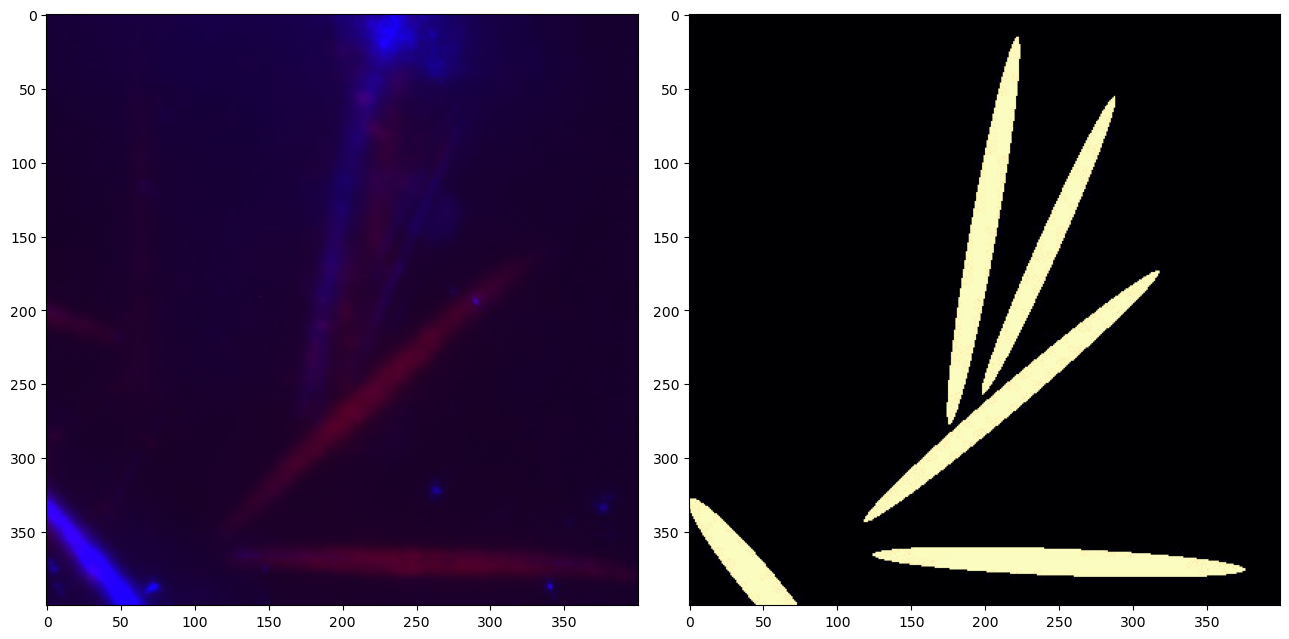

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
ax[0].imshow(tiled_x_cell[0], cmap='magma')
ax[1].imshow(tiled_y_cell[0], cmap='magma')
#ax[0].set_title(image_id_list[0])
#ax[1].set_title(mask_id_list[0])
fig.tight_layout()

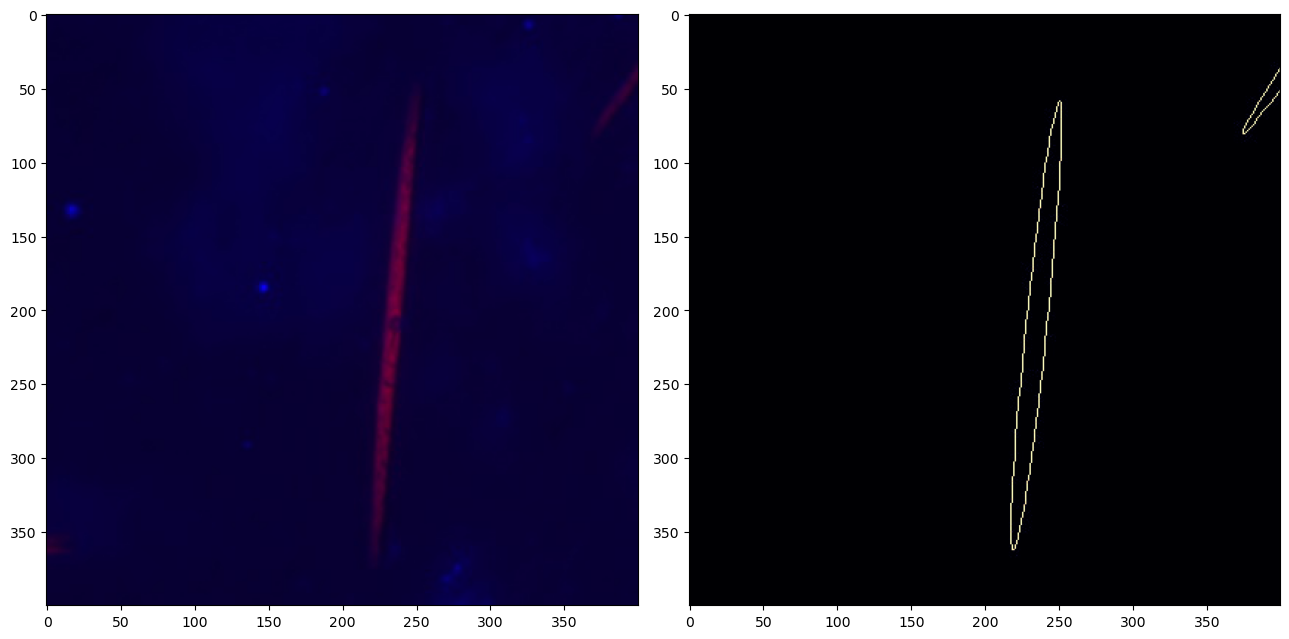

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
ax[0].imshow(tiled_x_outline[2], cmap='magma')
ax[1].imshow(tiled_y_outline[2], cmap='magma')
#ax[0].set_title(image_id_list[0])
#ax[1].set_title(mask_id_list[0])
fig.tight_layout()

Above are examples of the image chunks that were generated by this approach.  We can further augment our otherwise training set by applying rotations and inversions to the images - specifically there are three possible 90 degree rotations and two possible inversions (left-right, up-down).  Some data scientists also play with image intensity and distortion, but I would rather not do that here given the relatively consistent size and shape of the cells.

In [17]:
augmented_X_cell,augmented_y_cell=[],[]

for X,y in zip(tiled_x_cell,tiled_y_cell):
    augmented_X_cell.append(X)
    augmented_y_cell.append(y)

for X,y in zip(tiled_x_cell,tiled_y_cell):
    augmented_X_cell.append(np.rot90(X))
    augmented_y_cell.append(np.rot90(y))

for X,y in zip(tiled_x_cell,tiled_y_cell):
    augmented_X_cell.append(np.fliplr(X))
    augmented_y_cell.append(np.fliplr(y))

for X,y in zip(tiled_x_cell,tiled_y_cell):
    augmented_X_cell.append(np.rot90(X,k=2))
    augmented_y_cell.append(np.rot90(y,k=2))

for X,y in zip(tiled_x_cell,tiled_y_cell):
    augmented_X_cell.append(np.flipud(X))
    augmented_y_cell.append(np.flipud(y))

for X,y in zip(tiled_x_cell,tiled_y_cell):
    augmented_X_cell.append(np.rot90(X,k=3))
    augmented_y_cell.append(np.rot90(y,k=3))


augmented_X_cell,augmented_y_cell=np.array(augmented_X_cell),np.array(augmented_y_cell)
augmented_X_cell.shape

(8424, 400, 400, 3)

In [18]:
augmented_y_cell.shape

(8424, 400, 400)

We now have 8400 training data images to work with.

In [19]:
augmented_X_outline,augmented_y_outline=[],[]

for X,y in zip(tiled_x_outline,tiled_y_outline):
    augmented_X_outline.append(X)
    augmented_y_outline.append(y)

for X,y in zip(tiled_x_outline,tiled_y_outline):
    augmented_X_outline.append(np.rot90(X))
    augmented_y_outline.append(np.rot90(y))

for X,y in zip(tiled_x_outline,tiled_y_outline):
    augmented_X_outline.append(np.fliplr(X))
    augmented_y_outline.append(np.fliplr(y))

for X,y in zip(tiled_x_outline,tiled_y_outline):
    augmented_X_outline.append(np.rot90(X,k=2))
    augmented_y_outline.append(np.rot90(y,k=2))

for X,y in zip(tiled_x_outline,tiled_y_outline):
    augmented_X_outline.append(np.flipud(X))
    augmented_y_outline.append(np.flipud(y))

for X,y in zip(tiled_x_outline,tiled_y_outline):
    augmented_X_outline.append(np.rot90(X,k=3))
    augmented_y_outline.append(np.rot90(y,k=3))


augmented_X_outline,augmented_y_outline=np.array(augmented_X_outline),np.array(augmented_y_outline)
print(augmented_X_outline.shape,augmented_y_outline.shape)

(3888, 400, 400, 3) (3888, 400, 400)


Now we can define the keras model architecture.  For now I am going to use identical structure and parameters for both the cell body and cell outline models.

In [21]:

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [22]:
IMG_CHANNELS=3
inputs = Input((400,400, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy',loss_weights=[1,1000])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

We must normalize our y data, which currently ranges from 0 to 255, to range from 0 to 1, as otherwise we will encounter issues in loss function calculation.

In [23]:
augmented_y_cell,augmented_y_outline=augmented_y_cell/255,augmented_y_outline/255

We will use a 90% train-test split for determining model out-of-sample accuracy.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(augmented_X_cell, augmented_y_cell, test_size=0.1, random_state=42)
augmented_X_cell,augmented_y_cell=[],[]

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7581, 400, 400, 3)
(7581, 400, 400)
(843, 400, 400, 3)
(843, 400, 400)


Now we can train the first model on the cell bodies.  I have allowed for 50 epochs (runs through the entire training data set) though in practice it will probably not need that many.  While training, we are interested in decreasing the model loss function.  The val_loss refers to loss calculated on the validation set (which is held out in training).  We have also enabled early stopping as neural networks, when allowed to run forever, tend to eventually stop learning meaningful patterns and begin memorizing data images, which results in a worsening of validation loss.  The early stopping functionality makes backups of the model after each epoch, then stops training and reverts to the previous best model as soon as the validation loss begins to worsen.

In [27]:

# ===========================================================
# Train the model
# ===========================================================

filepath = "models/cell_model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)


Epoch 1/50
427/427 [==============================] - ETA: 0s - loss: 0.1324   
Epoch 1: val_loss improved from inf to 0.09243, saving model to models\cell_model.h5
427/427 [==============================] - 1075s 3s/step - loss: 0.1324 - val_loss: 0.0924
Epoch 2/50
427/427 [==============================] - ETA: 0s - loss: 0.0808   
Epoch 2: val_loss improved from 0.09243 to 0.07851, saving model to models\cell_model.h5
427/427 [==============================] - 1058s 2s/step - loss: 0.0808 - val_loss: 0.0785
Epoch 3/50
427/427 [==============================] - ETA: 0s - loss: 0.0709   
Epoch 3: val_loss improved from 0.07851 to 0.07073, saving model to models\cell_model.h5
427/427 [==============================] - 1061s 2s/step - loss: 0.0709 - val_loss: 0.0707
Epoch 4/50
427/427 [==============================] - ETA: 0s - loss: 0.0642   
Epoch 4: val_loss improved from 0.07073 to 0.06242, saving model to models\cell_model.h5
427/427 [==============================] - 1039s 2s/ste

KeyboardInterrupt: 

In [31]:
model.load_weights('models/cell_model.h5')


In [32]:
in_sample_prediction=model.predict(X_train)

 19/237 [=>............................] - ETA: 2:42

KeyboardInterrupt: 

In [ ]:
plt.imshow(augmented_X_train[3])

In [ ]:
plt.imshow(augmented_y_train[3])

In [ ]:
plt.imshow(in_sample_prediction[5])

In [ ]:
num=300
fig, ax = plt.subplots(1, 3, figsize=(13, 10))
ax[0].imshow(augmented_X_train[num], cmap='magma')
ax[1].imshow(augmented_y_train[num], cmap='magma')
ax[2].imshow(in_sample_prediction[num], cmap='magma')
fig.tight_layout()

1/1 [==============================] - 0s 286ms/step


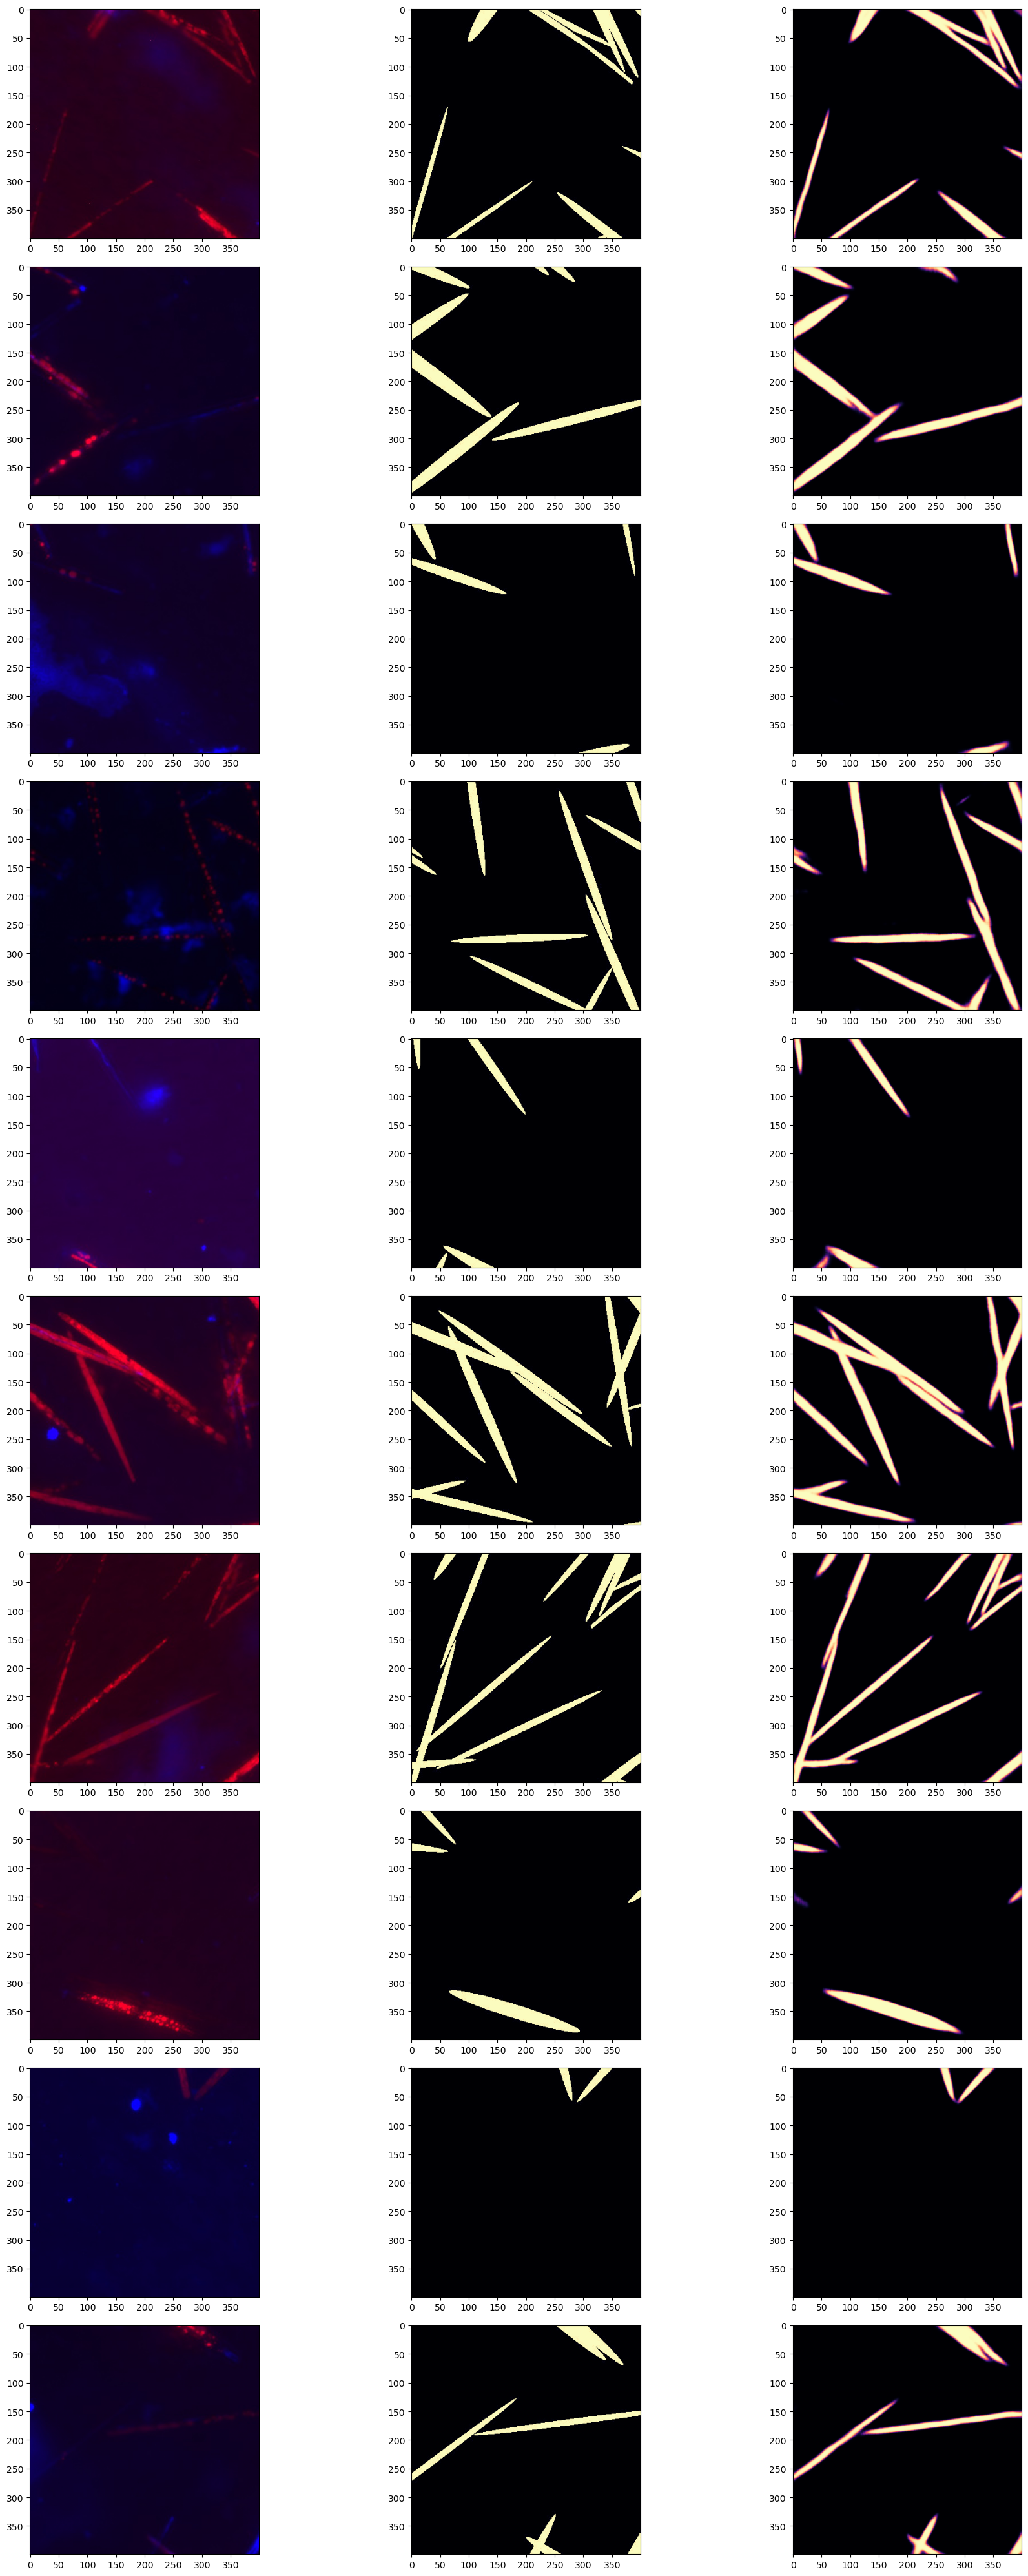

In [56]:
#show some in-sample predictions
predictions=model.predict(X_train[:10])
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(0,10):
    ax[i,0].imshow(X_train[i], cmap='magma')
    ax[i,1].imshow(y_train[i], cmap='magma')
    ax[i,2].imshow(predictions[i], cmap='magma')
    fig.tight_layout()

In [57]:
predictions=model.predict(X_test)

27/27 [==============================] - 20s 739ms/step


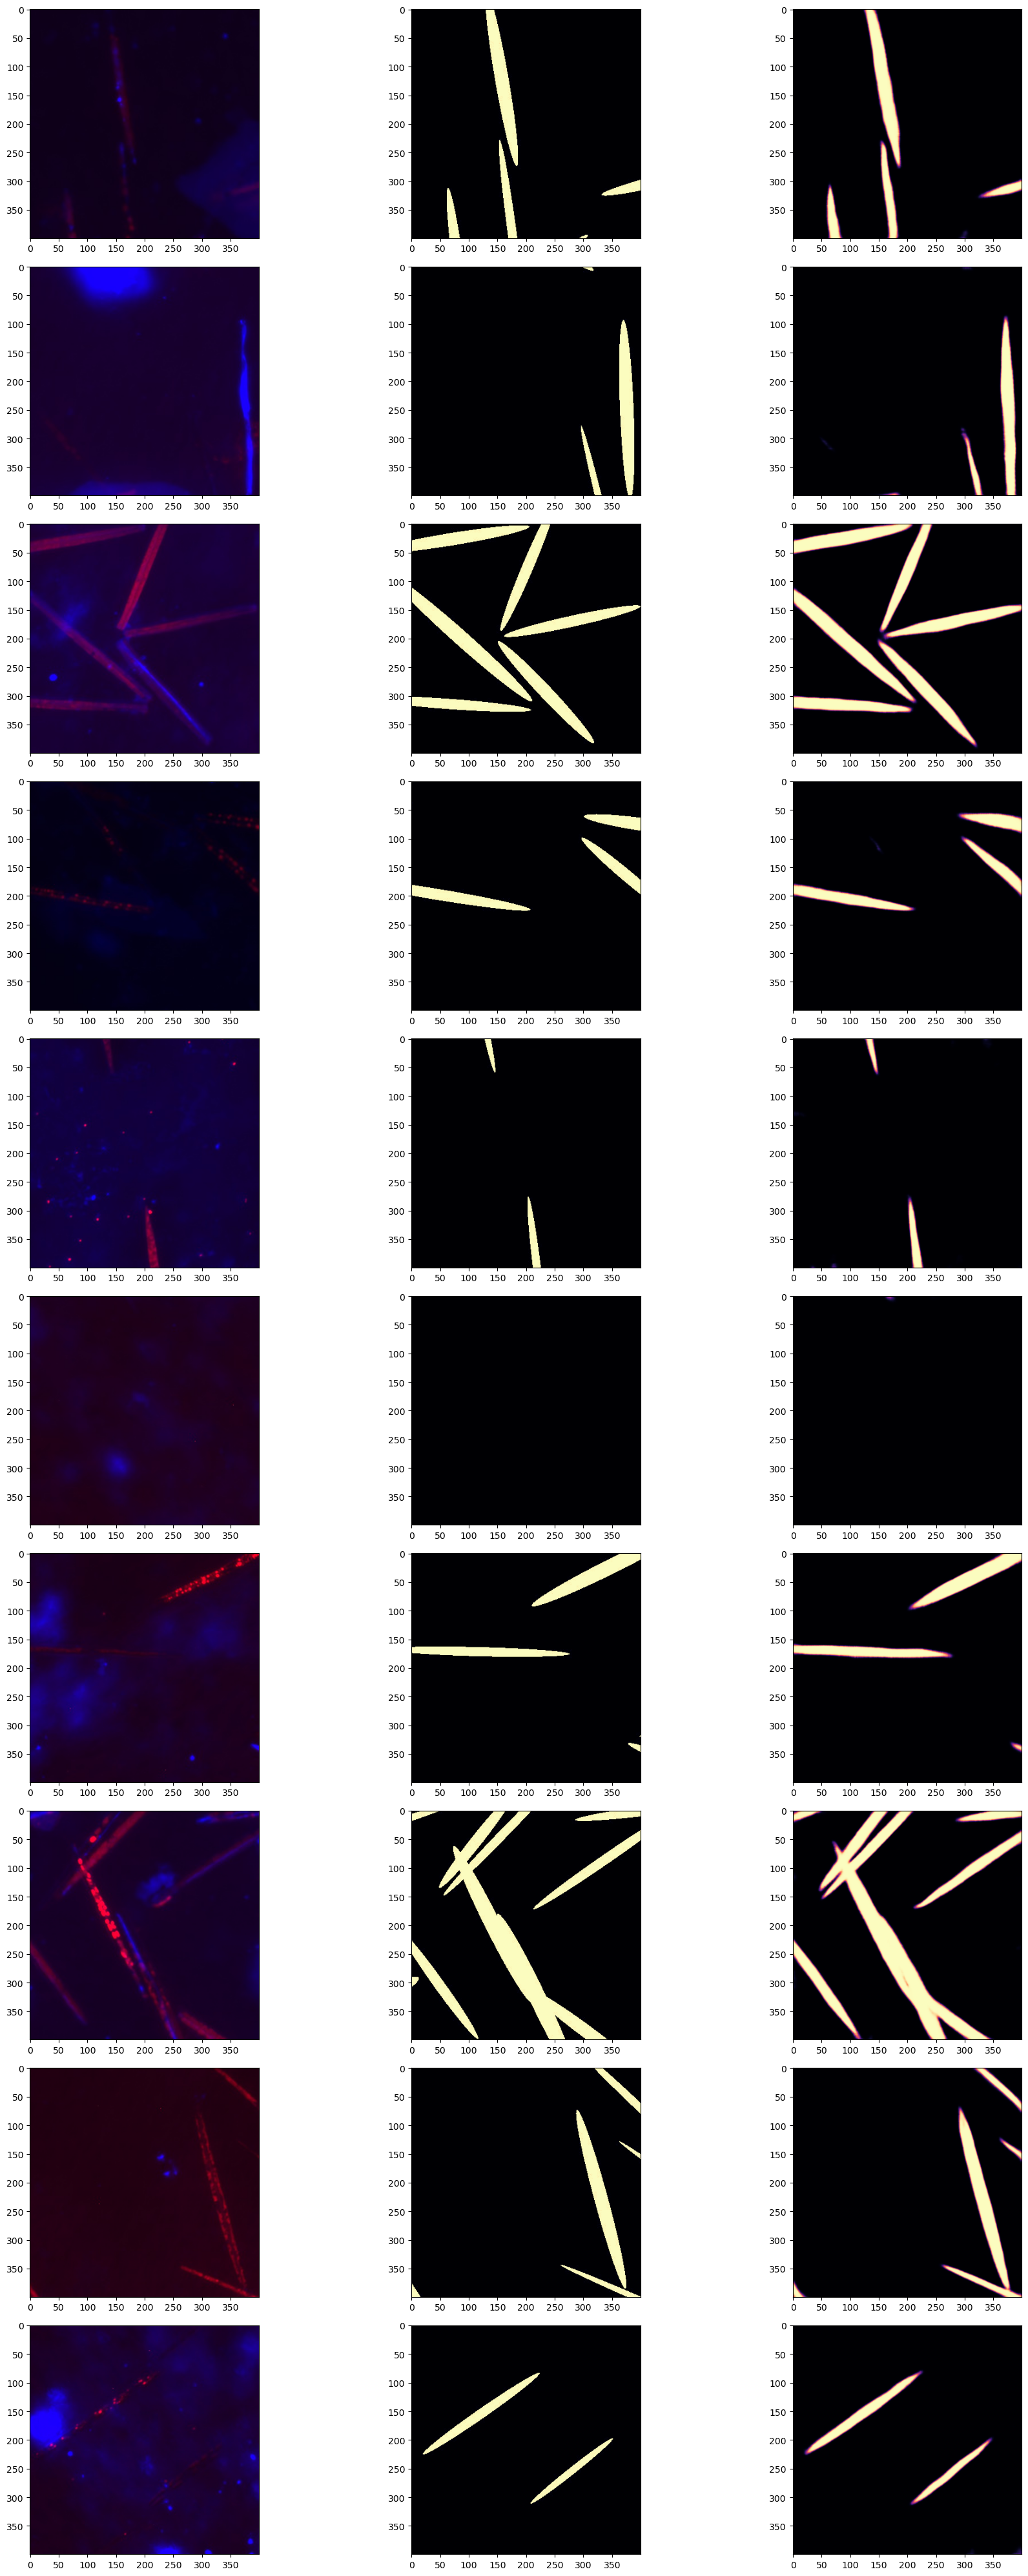

In [58]:
#show some out-of-sample predictions
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
for i in range(0,10):
    ax[i,0].imshow(X_test[i], cmap='magma')
    ax[i,1].imshow(y_test[i], cmap='magma')
    ax[i,2].imshow(predictions[i], cmap='magma')
    fig.tight_layout()

Nice!